In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
ERROR! Session/line number was not unique in database. History logging moved to new session 541


In [6]:
import glob, json
import numpy as np
import pandas as pd
import s4_authors_stats as s4
import dask.dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.stats import pearsonr, spearmanr
from matplotlib.colors import LogNorm

from functools import partial
from multiprocessing import Pool

In [7]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

In [8]:
pairs_authors_dd = dd.read_csv('data/pair_csv_1960_byAuthorIDprocessed_pairs.csv', sep='\t', header=None, names=['author_id', 'cits'])
pairs_authors_dd = pairs_authors_dd.set_index('author_id', sorted=True)
pairs_authors_dd.head()

,cits
author_id,
45600,"{""1250310513"": [62], ""2109936750"": [44], ""2141..."
115487,"{""1235265825"": [0], ""1981117217"": [0], ""209761..."
741248,"{""2332184452"": [10], ""2988917220"": [12], ""5885..."
980010,"{""2150231432"": [6], ""2631558439"": [0]}"
1022030,"{""1862885640"": [0], ""2118961492"": [0], ""212167..."


In [9]:
authors_infos = dd.read_json('data/author_infos_processed.txt', orient='index')
authors_infos.head()

,birth_year,citation_count
1243978490,2002,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0..."
2250382311,1982,"[0, 15.0, 2.0, 0, 0, 4.0, 1.0, 0, 87.0, 6.0, 6..."
2223209249,1994,"[0, 1.0, 2.0, 9.0, 4.0, 1.0, 4.0, 7.0, 2.0, 0,..."
2970207820,1994,"[2.0, 0, 1.0, 6.0, 44.0, 0, 0, 0, 2.0, 0, 0, 0..."
2112958178,1981,"[0, 0, 0, 0, 0, 6.0, 1.0, 0, 5.0, 0, 0, 3.0, 0..."


In [10]:
pairs_authors_dd = pairs_authors_dd.merge(authors_infos, left_index=True, right_index=True)
pairs_authors_dd.head()

,cits,birth_year,citation_count
45600,"{""1250310513"": [62], ""2109936750"": [44], ""2141...",1957,"[73.0, 13.0, 5.0, 0, 0, 54.0, 6.0, 377.0, 0, 2..."
115487,"{""1235265825"": [0], ""1981117217"": [0], ""209761...",1959,"[0, 12.0, 0, 0, 0, 0, 19.0, 3.0, 3.0, 0, 2.0, ..."
741248,"{""2332184452"": [10], ""2988917220"": [12], ""5885...",1950,"[4.0, 0, 10.0, 0, 0, 0, 13.0, 4.0, 2.0, 0, 0, ..."
980010,"{""2150231432"": [6], ""2631558439"": [0]}",1959,"[0, 0, 120.0, 1.0, 0, 0, 1.0, 0, 16.0, 0, 2.0,..."
1022030,"{""1862885640"": [0], ""2118961492"": [0], ""212167...",1950,"[5.0, 0, 0, 0, 0, 0, 0, 0, 3.0, 0, 0, 0, 0, 0,..."


In [11]:
header = '/mnt/e/MAG/mag-2021-01-05/advanced/'
fields_infos = 'FieldsOfStudy.txt'
fos_infos = pd.read_csv(header+fields_infos, header=None, sep='\t')[[0, 1, 2]]
fos_infos.columns = ['field_id', 'rank', 'normalized_name']

In [31]:
authors_fos = dd.read_csv('data/valid_authors_fos_full.csv', sep='\t', header=None, names=['author_id', 'weights', 'fos'], 
                         dtype={'fos': 'float'}).dropna(subset=['fos'])
print(authors_fos.head())
authors_fos['fos'] = authors_fos['fos'].astype(int)
authors_fos.head()

   author_id                                            weights          fos
0       5211  {"185592680": 2.600569523069523, "192562407": ...   86803240.0
1       6478  {"121332964": 0.10876623376623376, "71924100":...   86803240.0
2      11720  {"121332964": 6.217338772338771, "185592680": ...  185592680.0
3      15251  {"127313418": 0.3997965768799102, "86803240": ...   86803240.0
4      16490  {"121332964": 3.3598429096156375, "205649164":...   86803240.0


,author_id,weights,fos
0,5211,"{""185592680"": 2.600569523069523, ""192562407"": ...",86803240
1,6478,"{""121332964"": 0.10876623376623376, ""71924100"":...",86803240
2,11720,"{""121332964"": 6.217338772338771, ""185592680"": ...",185592680
3,15251,"{""127313418"": 0.3997965768799102, ""86803240"": ...",86803240
4,16490,"{""121332964"": 3.3598429096156375, ""205649164"":...",86803240


In [32]:
authors_complete = authors_fos.merge(pairs_authors_dd, left_on='author_id', right_index=True)
authors_complete.head()

,author_id,weights,fos,cits,birth_year,citation_count
15,45600,"{""121332964"": 5.371206899825319, ""192562407"": ...",185592680,"{""1250310513"": [62], ""2109936750"": [44], ""2141...",1957,"[73.0, 13.0, 5.0, 0, 0, 54.0, 6.0, 377.0, 0, 2..."
49,115487,"{""127413603"": 3.0520803270803274, ""17744445"": ...",162324750,"{""1235265825"": [0], ""1981117217"": [0], ""209761...",1959,"[0, 12.0, 0, 0, 0, 0, 19.0, 3.0, 3.0, 0, 2.0, ..."
289,741248,"{""127413603"": 0.5529439696106362, ""192562407"":...",86803240,"{""2332184452"": [10], ""2988917220"": [12], ""5885...",1950,"[4.0, 0, 10.0, 0, 0, 0, 13.0, 4.0, 2.0, 0, 0, ..."
366,980010,"{""121332964"": 135.3114317601313, ""33923547"": 7...",121332964,"{""2150231432"": [6], ""2631558439"": [0]}",1959,"[0, 0, 120.0, 1.0, 0, 0, 1.0, 0, 16.0, 0, 2.0,..."
383,1022030,"{""138885662"": 4.530555555555556, ""142362112"": ...",17744445,"{""1862885640"": [0], ""2118961492"": [0], ""212167...",1950,"[5.0, 0, 0, 0, 0, 0, 0, 0, 3.0, 0, 0, 0, 0, 0,..."


In [33]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    authors_complete.to_csv('data/AuthorsMetrics_split/authors_metrics_1960_*', sep='\t', header=None)

[########################################] | 100% Completed |  1min  4.0s


In [35]:
from s4_authors_stats import _step_1

authors_complete = dd.read_csv('data/AuthorsMetrics_split/authors_metrics_1960_*', sep='\t', header=None)
print(authors_complete.head())
authors_complete = authors_complete.set_index(1, sorted=True)
print(authors_complete.head())

     0        1                                                  2          3  \
0   15    45600  {"121332964": 5.371206899825319, "192562407": ...  185592680   
1   49   115487  {"127413603": 3.0520803270803274, "17744445": ...  162324750   
2  289   741248  {"127413603": 0.5529439696106362, "192562407":...   86803240   
3  366   980010  {"121332964": 135.3114317601313, "33923547": 7...  121332964   
4  383  1022030  {"138885662": 4.530555555555556, "142362112": ...   17744445   

                                                   4     5  \
0  {"1250310513": [62], "2109936750": [44], "2141...  1957   
1  {"1235265825": [0], "1981117217": [0], "209761...  1959   
2  {"2332184452": [10], "2988917220": [12], "5885...  1950   
3             {"2150231432": [6], "2631558439": [0]}  1959   
4  {"1862885640": [0], "2118961492": [0], "212167...  1950   

                                                   6  
0  [73.0, 13.0, 5.0, 0, 0, 54.0, 6.0, 377.0, 0, 2...  
1  [0, 12.0, 0, 0, 0, 0, 19.0,

In [36]:
authors_complete = authors_complete[[2, 3, 4, 5, 6]]
authors_complete.columns = ['weights', 'fos', 'cits', 'birth_year', 'citation_count']
authors_complete.head()

,weights,fos,cits,birth_year,citation_count
1,,,,,
45600,"{""121332964"": 5.371206899825319, ""192562407"": ...",185592680,"{""1250310513"": [62], ""2109936750"": [44], ""2141...",1957,"[73.0, 13.0, 5.0, 0, 0, 54.0, 6.0, 377.0, 0, 2..."
115487,"{""127413603"": 3.0520803270803274, ""17744445"": ...",162324750,"{""1235265825"": [0], ""1981117217"": [0], ""209761...",1959,"[0, 12.0, 0, 0, 0, 0, 19.0, 3.0, 3.0, 0, 2.0, ..."
741248,"{""127413603"": 0.5529439696106362, ""192562407"":...",86803240,"{""2332184452"": [10], ""2988917220"": [12], ""5885...",1950,"[4.0, 0, 10.0, 0, 0, 0, 13.0, 4.0, 2.0, 0, 0, ..."
980010,"{""121332964"": 135.3114317601313, ""33923547"": 7...",121332964,"{""2150231432"": [6], ""2631558439"": [0]}",1959,"[0, 0, 120.0, 1.0, 0, 0, 1.0, 0, 16.0, 0, 2.0,..."
1022030,"{""138885662"": 4.530555555555556, ""142362112"": ...",17744445,"{""1862885640"": [0], ""2118961492"": [0], ""212167...",1950,"[5.0, 0, 0, 0, 0, 0, 0, 0, 3.0, 0, 0, 0, 0, 0,..."


In [37]:
# h_index, cits, n_papers, birth, max_ws, max_colabs, citation_list, colabs_cit_list, authors_id = s4.step_1(pairs_authors_dd)
# with ProgressBar():
#     s4.step_1(authors_complete).to_csv('data/AuthorsMetrics_split/authors_v2_metrics_*', sep='\t', header=None)

H, C, P, WS, WP, CL, Y, CH, FOS = s4.step_1(authors_complete)

40354it [00:06, 5863.11it/s]


In [38]:
# open('results/hindex_full_1960.json','w').write(json.dumps(H))
# open('results/cits_full_1960.json','w').write(json.dumps(C))
# open('results/papers_full_1960.json','w').write(json.dumps(P))
# open('results/ws_full_1960.json','w').write(json.dumps(WS))
# open('results/wp_full_1960.json','w').write(json.dumps(WP))
# open('results/citlist_full_1960.json','w').write(json.dumps(CL))
# open('results/birth_full_1960.json', 'w').write(json.dumps(Y))
# open('results/fos_full_1960.json','w').write(json.dumps(FOS))
# open('results/ch_full_1960.json', 'w').write(json.dumps(CH))

16492368

In [39]:
H = json.load(open('results/hindex_full_1960.json'))
C = json.load(open('results/cits_full_1960.json'))
P = json.load(open('results/papers_full_1960.json'))
WS = json.load(open('results/ws_full_1960.json'))
WP = json.load(open('results/wp_full_1960.json'))
CL = json.load(open('results/citlist_full_1960.json'))
Y = json.load(open('results/birth_full_1960.json'))
CH = json.load(open('results/ch_full_1960.json'))
FOS = json.load(open('results/fos_full_1960.json'))

In [40]:
unique = np.unique(FOS)
H = np.asarray(H)
C = np.asarray(C)
P = np.asarray(P)
WS = np.asarray(WS)
WP = np.asarray(WP)
CL = np.asarray(CL)
Y = np.asarray(Y)
CH = np.asarray(CH)
FOS = np.asarray(FOS)
#TODO ajeitar o HINDEX pra rank funcionar

/home/acmbrito/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [41]:
header = '/mnt/e/MAG/mag-2021-01-05/advanced/'
fields_infos = 'FieldsOfStudy.txt'
fos_infos = pd.read_csv(header+fields_infos, header=None, sep='\t')[[0, 1, 2]]
fos_infos.columns = ['field_id', 'rank', 'normalized_name']

In [42]:
def fos_sort(max_ws, fos):
    values = []
    fs = []
    count = []
    for field in unique:
        group = max_ws[fos == field]
        median = np.percentile(group, 50)
        fs.append(field)
        values.append(median)
        count.append(len(group))
    values = np.asarray(values)
    fs = np.asarray(fs)
    count = np.asarray(count)
    idxs = np.argsort(values)
    values = values[idxs]
    fs = fs[idxs]
    count = count[idxs]
    
    return fs, count

fos_sorted, _ = fos_sort(WS, FOS)

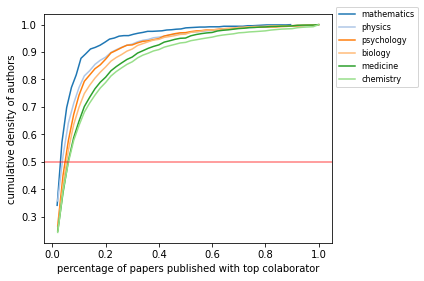

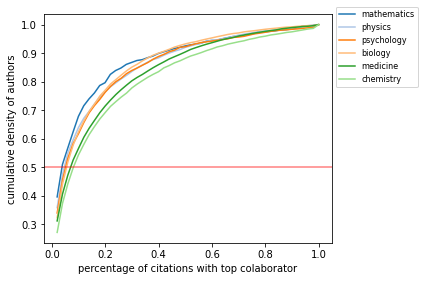

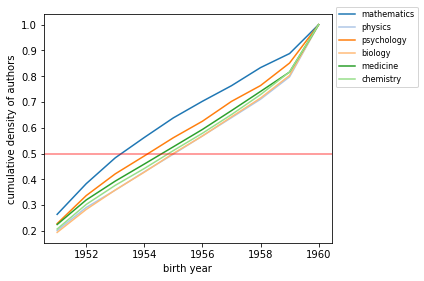

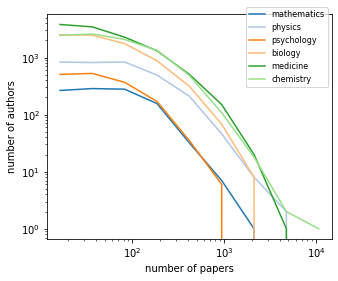

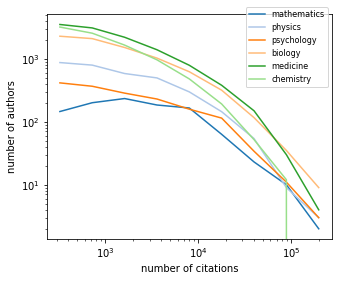

In [43]:
def plot_hist(fig, group, bins, field_name, cumulative):
    y,x = np.histogram(group, bins=bins)
    if cumulative:
        y = np.cumsum(y)
        fig.plot(x[1:], y/y[-1], label=field_name)
    else:
        bins_center = 0.5*(x[:-1]+x[1:])
        fig.plot(bins_center,y, label=field_name)
    
def basic_hist(unique, fos, data, key, suffix, bins, yscale=None, xscale=None, cumulative=False):
    fig, ax = plt.subplots()
    
    for field in unique:
        group = data[fos == field]
        if len(group) < 1000:
            continue
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        plot_hist(ax, group, bins, field_name, cumulative)

    ax.legend(bbox_to_anchor=(1.0, 1.05), prop={'size': 8})
    if cumulative:
        ax.axhline(0.5, xmin=0, xmax=1, color='red', alpha=0.5)
    if yscale:
        ax.set_yscale(yscale)
    if xscale:
        ax.set_xscale(xscale)
    ax.set_title(labels_description[key]['title'])
    ax.set_xlabel(labels_description[key]['x'])
    ax.set_ylabel(labels_description[key]['y'])
    fig.subplots_adjust(right=0.2)
    fig.tight_layout()
    fig.savefig('outputs/fos_hist_%s%s.pdf' % (key,suffix))
    fig.show()

labels_description = {
    'max_colabs': {'x': 'percentage of papers published with top colaborator', 'y': 'cumulative density of authors', 'title': ''},
    'max_ws': {'x': 'percentage of citations with top colaborator', 'y': 'cumulative density of authors', 'title': ''},
    'birth': {'x': 'birth year', 'y': 'cumulative density of authors', 'title': ''},
    'papers': {'x': 'number of papers', 'y': 'number of authors', 'title': ''},
    'total_cits': {'x': 'number of citations', 'y': 'number of authors', 'title': ''} 
}    

basic_hist(fos_sorted, FOS, WP, 'max_colabs', suffix='_1960', bins=50, cumulative=True) # papers
basic_hist(fos_sorted, FOS, WS, 'max_ws', suffix='_1960', bins=50, cumulative=True) # citações
basic_hist(fos_sorted, FOS, Y, 'birth', suffix='_1960', bins=10, cumulative=True)
xspace = np.logspace(np.log10(min(P)), np.log10(max(P)), 10)
basic_hist(fos_sorted, FOS, P, 'papers', suffix='_1960', bins=xspace, yscale='log', xscale='log')
xspace = np.logspace(np.log10(min(C)), np.log10(max(C)), 10)
basic_hist(fos_sorted, FOS, C, 'total_cits', suffix='_1960', bins=xspace, yscale='log', xscale='log')

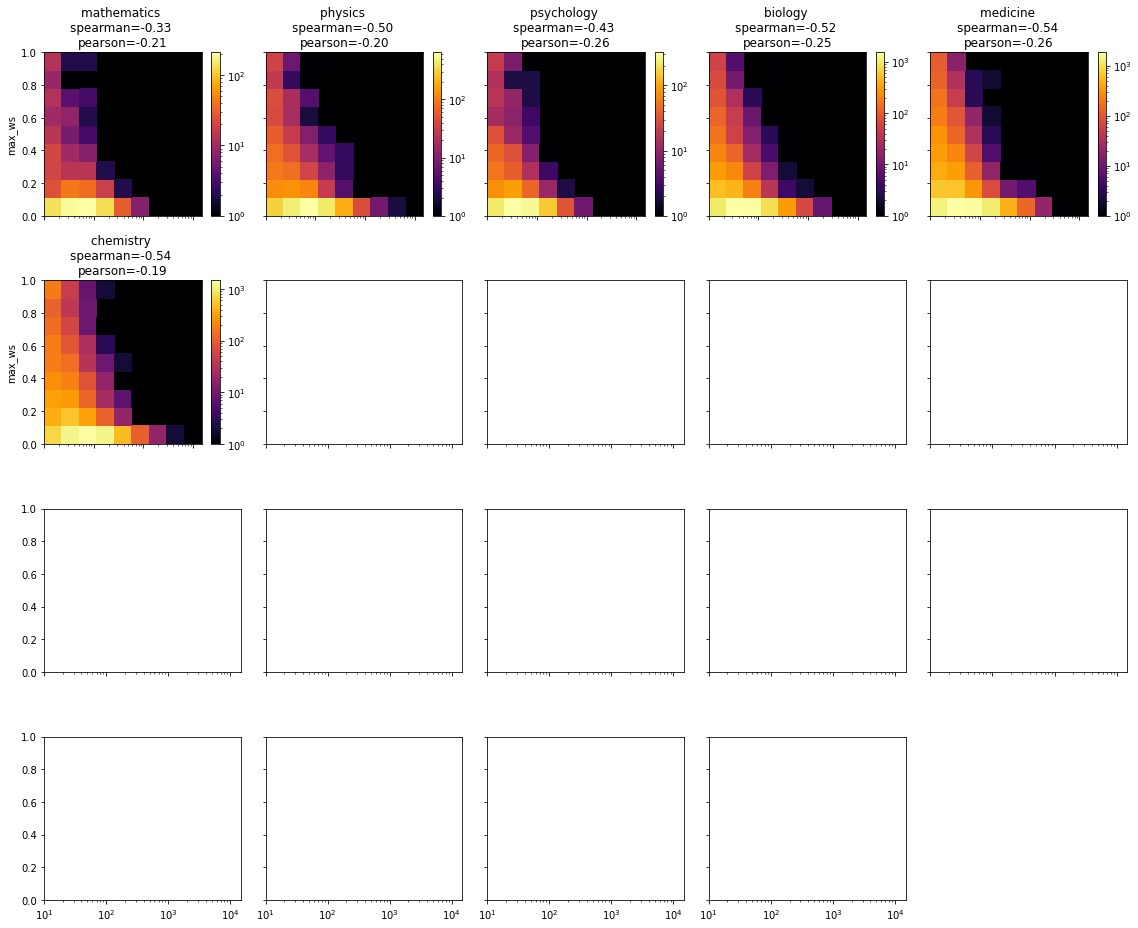

In [44]:
def _hist2d(ax, xgroup, ygroup, xspace, yspace, field_name): 
    ax.set_facecolor("black")
    im = ax.hist2d(xgroup, ygroup, bins=(xspace, yspace), cmap='inferno', norm=LogNorm()) #vmin=1,vmax=10000))
    ax.set_title("%s \nspearman=%.2f \npearson=%.2f" % (field_name, spearmanr(xgroup, ygroup)[0], pearsonr(xgroup, ygroup)[0]))
    return im
    
def hist2d(unique, fos, xdata, ydata, xkey, ykey, suffix, xbins, ybins, yscale=None, xscale=None):
    fig, axs = plt.subplots(figsize=(16, 13), nrows=4, ncols=5, sharex=True, sharey=True)
    i = 0
    for field in unique:
        xgroup = xdata[fos == field]
        ygroup = ydata[fos == field]
        if len(xgroup) < 1000:
            continue
        ax = axs[int(i/5)][i%5]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = _hist2d(ax, xgroup, ygroup, xbins, ybins, field_name=field_name)

        if yscale:
            ax.set_yscale(yscale)
        if xscale:
            ax.set_xscale(xscale)
    
        if i%5 == 0: 
            ax.set_ylabel(ykey)
        if int(i/5) == 3:    
            ax.set_xlabel(xkey)
        
        fig.colorbar(im[3], ax=ax)
        
        i += 1
    axs[-1,-1].axis('off')
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_%s_%s%s.pdf' % (xkey, ykey, suffix))
    fig.show()
    
xbins = np.logspace(np.log10(min(P)), np.log10(max(P)+1), 10)
ybins = np.linspace(min(WS), max(WS), 10)
hist2d(fos_sorted, FOS, P, WS, 'papers', 'max_ws', '1960', xbins=xbins, ybins=ybins, xscale='log', yscale=None)

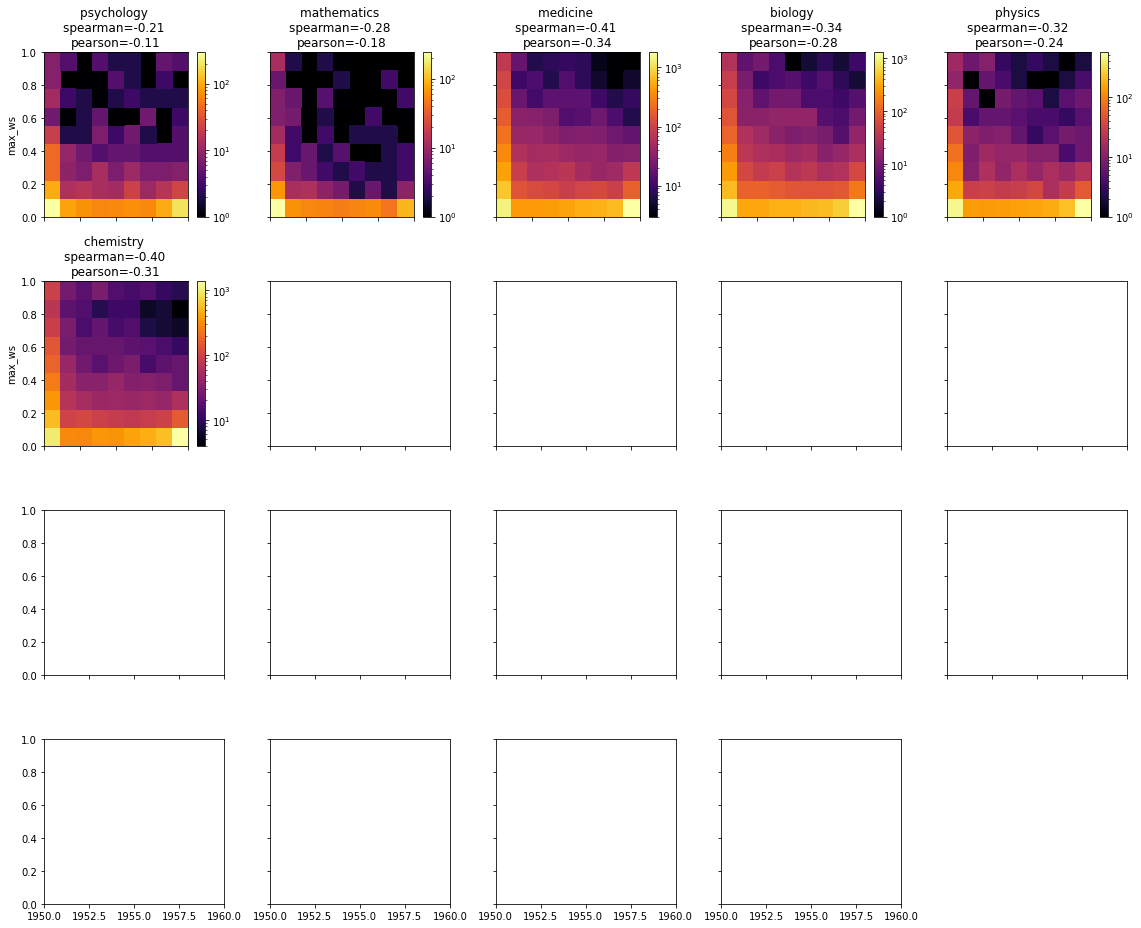

In [46]:
xbins = np.linspace(min(Y), max(Y), 10)
ybins = np.linspace(min(WS), max(WS), 10)
hist2d(unique, FOS, Y, WS, 'birth', 'max_ws', suffix='1960', xbins=xbins, ybins=ybins, xscale=None, yscale=None)

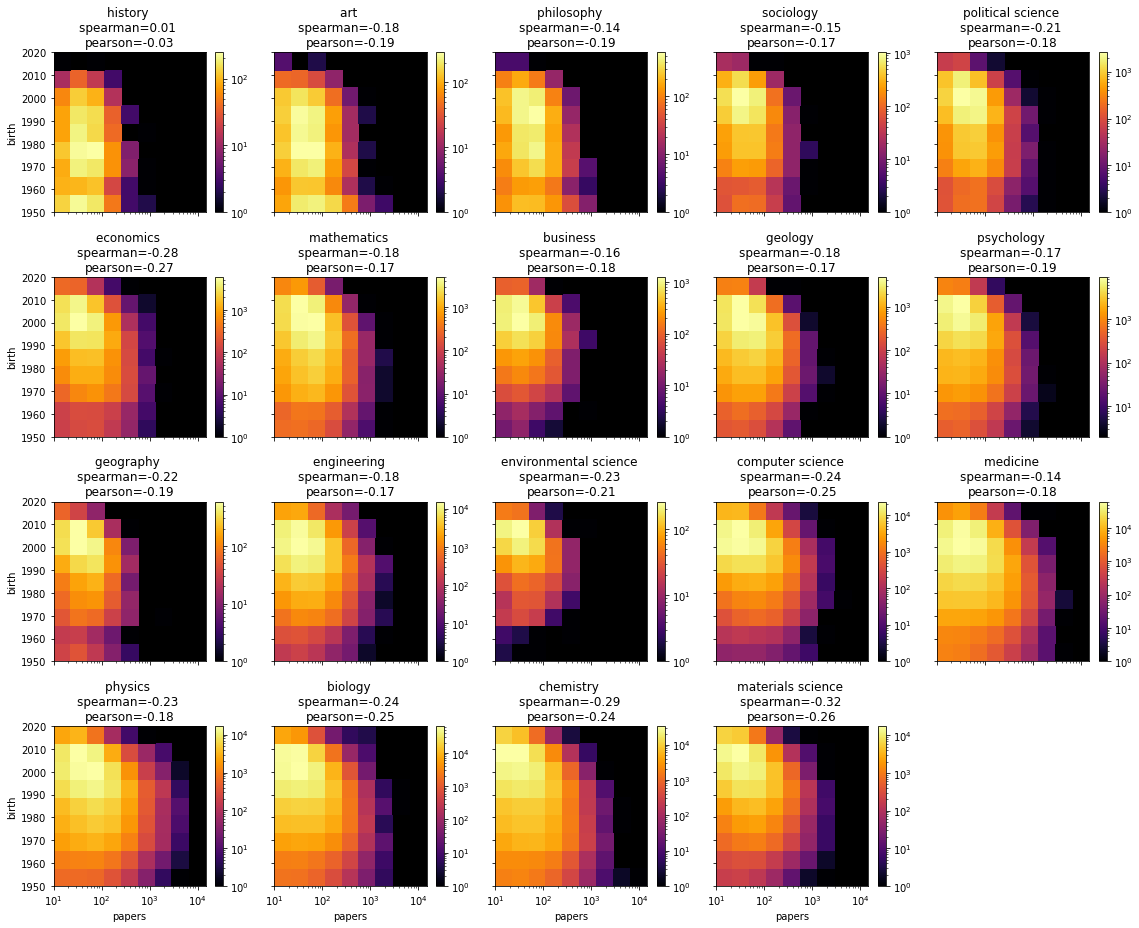

In [53]:
xbins = np.logspace(np.log10(min(P)), np.log10(max(P)+1), 10)
ybins = np.linspace(min(Y), max(Y), 10)
hist2d(fos_sorted, FOS, P, Y, 'papers', 'birth', xbins=xbins, ybins=ybins, xscale='log', yscale=None)

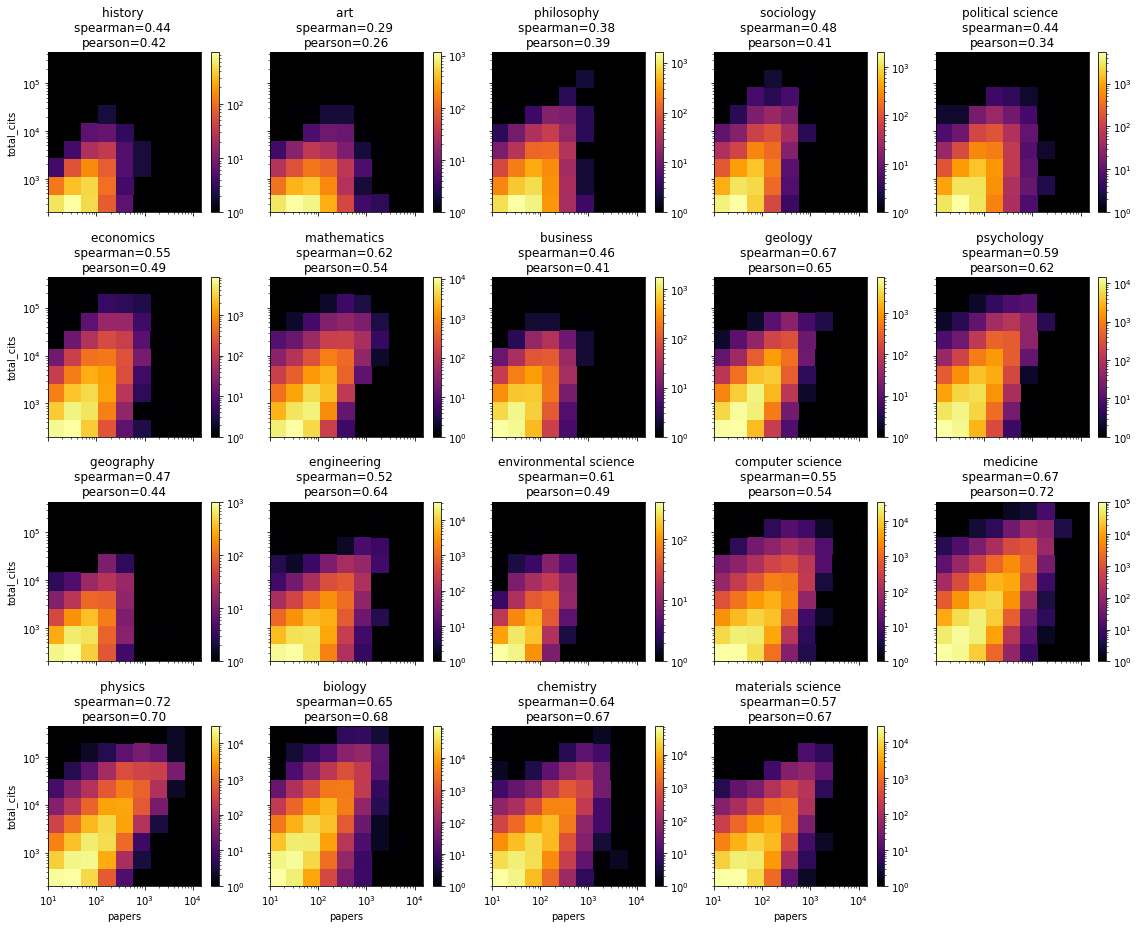

In [54]:
xbins = np.logspace(np.log10(min(P)), np.log10(max(P)+1), 10)
ybins = np.logspace(np.log10(min(C)), np.log10(max(C)+1), 10)
hist2d(fos_sorted, FOS, P, C, 'papers', 'total_cits', xbins=xbins, ybins=ybins, xscale='log', yscale='log')

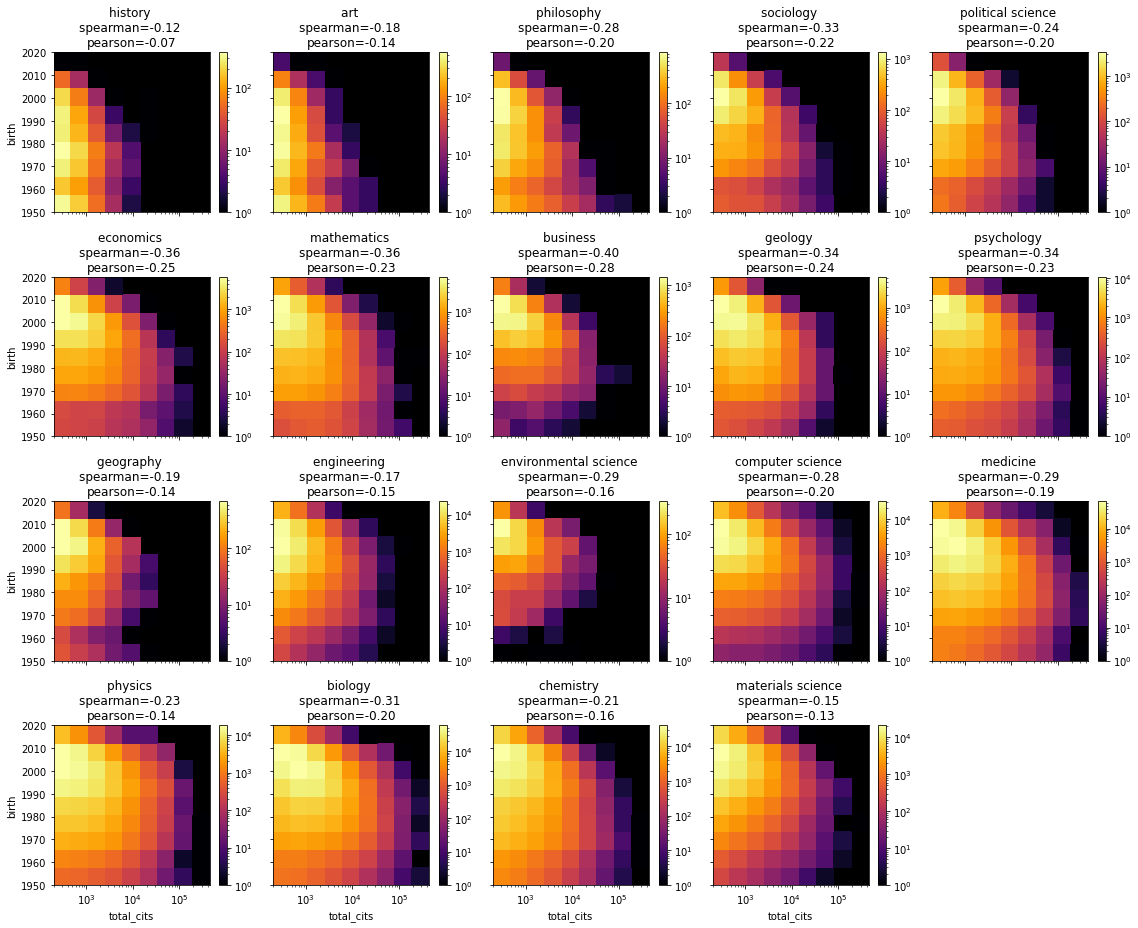

In [55]:
xbins = np.logspace(np.log10(min(C)), np.log10(max(C)+1), 10)
ybins = np.linspace(min(Y), max(Y), 10)
hist2d(fos_sorted, FOS, C, Y, 'total_cits', 'birth', xbins=xbins, ybins=ybins, xscale='log', yscale=None)

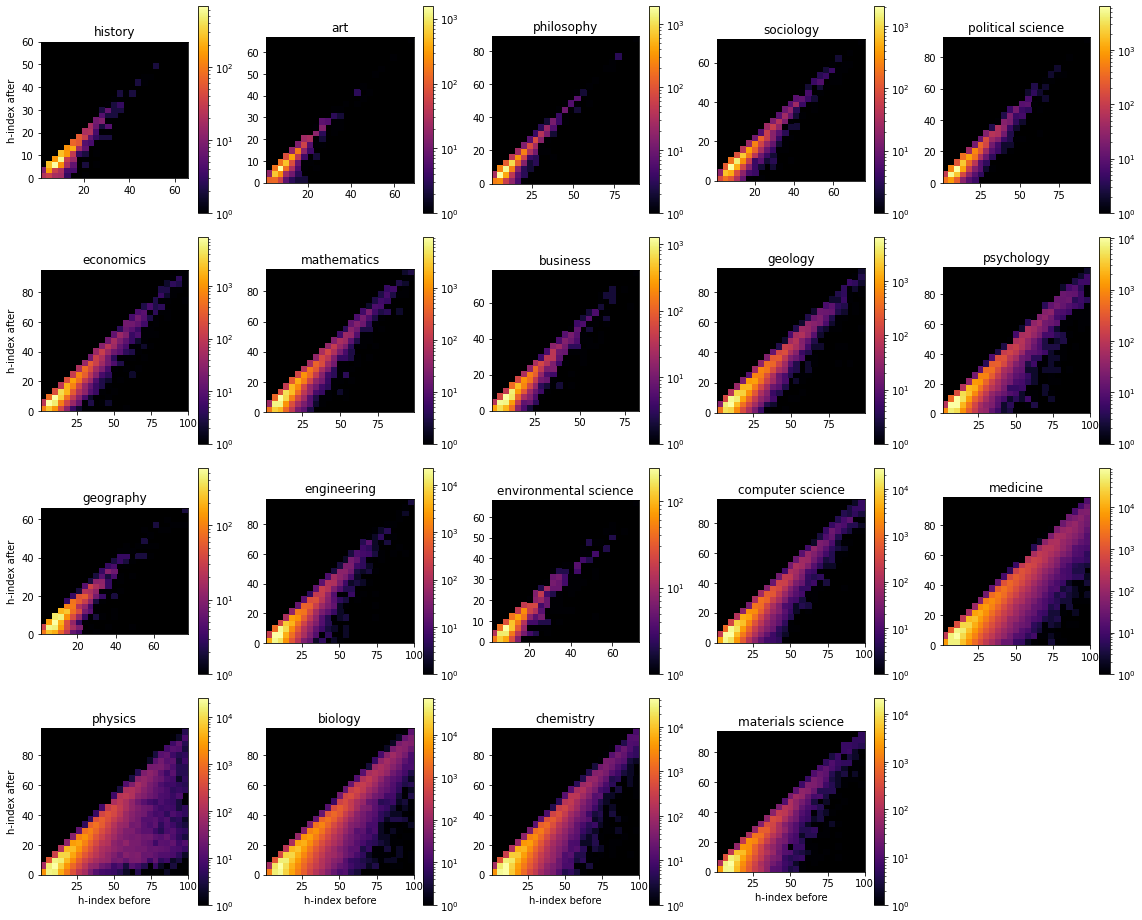

In [56]:
from s4_authors_stats import get_h_index

def _hindex_before_after(ax, idxs, field_name):
    valid_colabs_cit_list = CL[idxs]
    valid_citation_list = CH[idxs]
    valid_h_index = H[idxs]
    hindex_after = []
    
    for ccits, acits in zip(valid_colabs_cit_list, valid_citation_list):
        diff_cits = acits.copy() # json.loads(acits)
        for ctemp in ccits: # json.loads(ccits):
            diff_cits.remove(ctemp)
            
        hafter = get_h_index(diff_cits)
        hindex_after.append(hafter)
    
    hindex_before_l1 = np.asarray([row[0] for row in valid_h_index])
    hindex_after_l1 = np.asarray(hindex_after)[:,0]
    
    ax.set_facecolor("black")
    im = ax.hist2d(hindex_before_l1[hindex_before_l1 <= 100], hindex_after_l1[hindex_before_l1 <= 100], 
           norm=LogNorm(), cmap='inferno', bins=(25, 25))
    ax.set_aspect('equal')
    ax.set_title(field_name)
    
    return im, hindex_after 


def hindex_before_after():
    fig, axs = plt.subplots(figsize=(16, 13), nrows=4, ncols=5) #sharex=True, sharey=True)
    i = 0
    hafter_map = {}
    for field in fos_sorted:
        group = (FOS == field)
        if np.count_nonzero(group) < 1000:
            continue
        ax = axs[int(i/5)][i%5]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im, hafter = _hindex_before_after(ax, group, field_name=field_name)
        hafter_map[field] = hafter
    
        if i%5 == 0: 
            ax.set_ylabel('h-index after')
        if int(i/5) == 3:    
            ax.set_xlabel('h-index before')
        
        fig.colorbar(im[3], ax=ax)
        
        i += 1
    axs[-1,-1].axis('off')
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_before_after.pdf')
    fig.show()
    
    return hafter_map

hafter_map = hindex_before_after()

In [ ]:
import tqdm
# from tqdm.auto import tqdm

def rank(values, i, new_val):
    old = values[i]
    new_pair = np.array([(new_val[0], new_val[1], new_val[2], old[3])], dtype=[('my_val1', int), ('my_val2', int), ('my_val3', int), ('my_val4', int)])
    new_rank = np.searchsorted(values, new_pair[0], side='right')
    return new_rank

def get_rank_after(hindexbefore, i, ccits, acits):
    diff_cits = acits.copy() #json.loads(acits)
    for ctemp in ccits: #json.loads(ccits):
        diff_cits.remove(ctemp)
    hafter = get_h_index(diff_cits)
    rafter = rank(hindexbefore, i, (-hafter[0], -hafter[1], -hafter[2]))
    return rafter

def _plot_rank(ax, idxs, hindex_after, field_name):
    valid_h_index = H[idxs]
    
    valid_colabs_cit_list = CL[idxs]
    valid_citation_list = CH[idxs]
    
    neg_hindex = np.array([(-row[0], -row[1], -row[2], i) for i,row in enumerate(valid_h_index)], 
                          dtype=[('my_val1', int), ('my_val2', int), ('my_val3', int), ('my_val4', int)])
    neg_hindex_sorted = np.sort(neg_hindex)
    rankbefore = rankdata(neg_hindex, method='ordinal')

    results = []
    for a,b,c in tqdm.tqdm(zip(np.arange(len(neg_hindex)), valid_colabs_cit_list, valid_citation_list), total=len(neg_hindex)):
        results.append(get_rank_after(neg_hindex_sorted, a,b,c)) 
    
    ax.set_facecolor("black")
    ax.set_aspect('equal')
    
    im = ax.hist2d(rankbefore, results, bins=50, cmap='inferno', norm=LogNorm())
    ax.set_title('%s \npearson = %.2f' % (field_name, pearsonr(rankbefore, results)[0]))
    ax.invert_yaxis()
    return im


def plot_rank(hafter_map):
    fig, axs = plt.subplots(figsize=(16, 13), nrows=4, ncols=5) # sharex=True, sharey=True)
    i = 0
    for field in fos_sorted:
        group = (FOS == field)
        if np.count_nonzero(group) < 1000:
            continue
        ax = axs[int(i/5)][i%5]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = _plot_rank(ax, group, hafter_map[field], field_name=field_name)
    
        if i%5 == 0: 
            ax.set_ylabel('author\'s rank by h-index')
        if int(i/5) == 3:    
            ax.set_xlabel('author\'s rank by h-index\n excluding their main collaborator')
    
        fig.colorbar(im[3], ax=ax)
        
        i += 1
    
    axs[-1,-1].axis('off')

    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_hrank.pdf')
    fig.show()
    
plot_rank(hafter_map)


100%|██████████| 146450/146450 [00:04<00:00, 34394.59it/s]


In [ ]:
def _nauthors(f):
    print(f)
    chunk = pd.read_csv(f, header=None, sep='\t',
                names=['paper_id', 'doi', 'year', 'authors', 'total_cits', 'cits',])
    nauthors = []
    for _,row in chunk.iterrows():
        year = row['year']
        if not year or type(year) != type(1.0) or year < 1950:
            continue
        n = 1 + row['authors'].count(',')
        nauthors.append(n)
    del chunk
    return nauthors

files_input = glob.glob('data/PaperCompleteInfos_split/*')

pool = Pool(16)
nauthors_temp = pool.map(_nauthors, files_input)

data/PaperCompleteInfos_split/paper_comp_info_00064


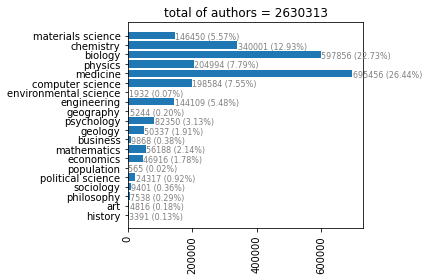

In [49]:
_, count = fos_sort(WS, FOS)
labels = [fos_infos[fos_infos['field_id'] == u].iloc[0, -1] for u in fos_sorted]

plt.barh(np.arange(1, len(count)+1), count, tick_label=labels)
plt.title('total of authors = %d' % len(FOS))
plt.xticks(rotation='vertical')
ax = plt.gca()
for i, v in enumerate(count):
    ax.text(v + 1500, i + .6, "%d (%.2f%%)" % (v, 100*v/len(FOS)), color='gray', size=8)
plt.tight_layout()
plt.savefig('authors_distribution.pdf')